# Walen Test
author: Louis Richard\
Example code to perform Walen test; only for burst mode MMS data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyrfu import mms, pyrf
from scipy import constants
from pyrfu.plot import plot_line, plot_spectr

Load IGRF coefficients ...


## Define spacecraft index, time intervals, jet direction and trasnformation matrix

In [2]:
mms.db_init("/Volumes/mms")

mms_id = 1
j_sign = 1  # +/-1 for jet direction

# time = irf_time('2015-11-30T00:23:55.200Z', 'utc>epochtt');
trans_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # in GSE

# Plot
tint = ["2015-11-30T00:23:48.000", "2015-11-30T00:24:01.000"]
# reference region
tint_ref = ["2015-11-30T00:23:49.000", "2015-11-30T00:23:50.000"]
# Test region
tint_walen = ["2015-11-30T00:23:50.000", "2015-11-30T00:23:54.000"]

## Load data

### PSD

In [3]:
vdf_i = mms.get_data("pdi_fpi_brst_l2", tint, mms_id)

[09-Jun-23 13:39:03] INFO: Loading mms1_dis_dist_brst...
[09-Jun-23 13:39:03] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_dist.py:68: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)



### Moments

In [4]:
n_i = mms.get_data("ni_fpi_brst_l2", tint, mms_id)
n_e = mms.get_data("ne_fpi_brst_l2", tint, mms_id)
v_gse_i = mms.get_data("vi_gse_fpi_brst_l2", tint, mms_id)
p_gse_i = mms.get_data("pi_gse_fpi_brst_l2", tint, mms_id)

[09-Jun-23 13:39:05] INFO: Loading mms1_dis_numberdensity_brst...
[09-Jun-23 13:39:05] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[09-Jun-23 13:39:05] INFO: Loading mms1_des_numberdensity_brst...
[09-Jun-23 13:39:05] INFO: Loading mms1_dis_bulkv_gse_brst...
[09-Jun-23 13:39:05] INFO: Loading mms1_dis_prestensor_gse_brst...
[09-Jun-23 13:39:05] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)



### Fields

In [5]:
b_gse = mms.get_data("b_gse_fgm_brst_l2", tint, mms_id)

[09-Jun-23 13:39:05] INFO: Loading mms1_fgm_b_gse_brst_l2...


### Load defatt files

In [6]:
defatt = mms.load_ancillary("defatt", tint, mms_id)

[09-Jun-23 13:39:06] INFO: Loading ancillary defatt files...
[09-Jun-23 13:39:11] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/load_ancillary.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(data_frame_dict[k])



## Compute

### Compute omnidirectionnal differential energy flux (DEF)

In [7]:
def_omni_i = mms.vdf_omni(mms.psd2def(vdf_i))

### Rotate pressure tensor into Field Aliigned Coordinates (FAC)

In [8]:
p_fac_i = mms.rotate_tensor(p_gse_i, "fac", b_gse)

[09-Jun-23 13:39:11] INFO: Using averages in resample


### Alpha: pressure anisotropy factor

In [9]:
alpha_ = pyrf.pres_anis(p_fac_i, b_gse)

[09-Jun-23 13:39:11] INFO: Using averages in resample


### gse to new123

In [10]:
b_123 = pyrf.new_xyz(b_gse, trans_matrix)
v_123_i = pyrf.new_xyz(v_gse_i, trans_matrix)

### Reference(MSH) region; in New frame(123);

In [11]:
b_ref = pyrf.time_clip(b_123, tint_ref)
b_ref = np.nanmean(b_ref.data, axis=0)

v_i_ref = pyrf.time_clip(v_123_i, tint_ref)
v_i_ref = np.nanmean(v_i_ref.data, axis=0)

n_i_ref = pyrf.time_clip(n_i, tint_ref)
n_i_ref = np.nanmean(n_i_ref.data, axis=0)

alpha_ref = pyrf.time_clip(alpha_, tint_ref)
alpha_ref = np.nanmean(alpha_ref.data, axis=0)

### Vipred1: delta_B / sqrt(rho1)

In [12]:
b_123 = pyrf.resample(b_123, n_i)
v_123_i = pyrf.resample(v_123_i, n_i)

tmp_1 = (b_123 - b_ref) * 21.8 / np.sqrt(n_i_ref)
v_i_pred1 = pyrf.resample(tmp_1, v_123_i) * j_sign + v_i_ref

[09-Jun-23 13:39:11] INFO: Using averages in resample


### Vipred2: $B_2 / \sqrt{\rho_2} - B_1 / \sqrt{\rho_1}$ [Phan et al, 2004]

In [13]:
tmp_2 = 21.8 * (1 - alpha_) * b_123 / np.sqrt(n_i_ref * (1 - alpha_ref))
v_i_pred2 = tmp_2 - 21.8 * np.sqrt(1 - alpha_ref) * b_ref / np.sqrt(n_i_ref)
v_i_pred2 *= j_sign
v_i_pred2 += v_i_ref

### Vipred2: $\sqrt{1 - \alpha_2}  B_2 / \sqrt{\rho_2} - \sqrt{1 - \alpha_1} B_1 / \sqrt{\rho_1}$

In [14]:
v_i_pred3 = 21.8 * (1 - alpha_) * b_123 / np.sqrt(n_i)
v_i_pred3 -= 21.8 * np.sqrt(1 - alpha_ref) * b_ref / np.sqrt(n_i_ref)
v_i_pred3 *= j_sign
v_i_pred3 += v_i_ref

### Slope & CC

In [15]:
v_123_i_w = pyrf.time_clip(v_123_i, tint_walen)
v_i_pred1_w = pyrf.time_clip(v_i_pred1, tint_walen)
v_i_pred2_w = pyrf.time_clip(v_i_pred2, tint_walen)
v_i_pred3_w = pyrf.time_clip(v_i_pred3, tint_walen)

In [16]:
p_ = [np.polyfit(v_i_pred2_w.data[:, i], v_123_i_w.data[:, i], 1) for i in range(3)]
slope_2 = [p_[i][0] for i in range(3)]

corr_ = [np.corrcoef(v_i_pred2_w.data[:, i], v_123_i_w.data[:, i]) for i in range(3)]
cc_2 = [corr_[i][0, 1] for i in range(3)]

## Plot

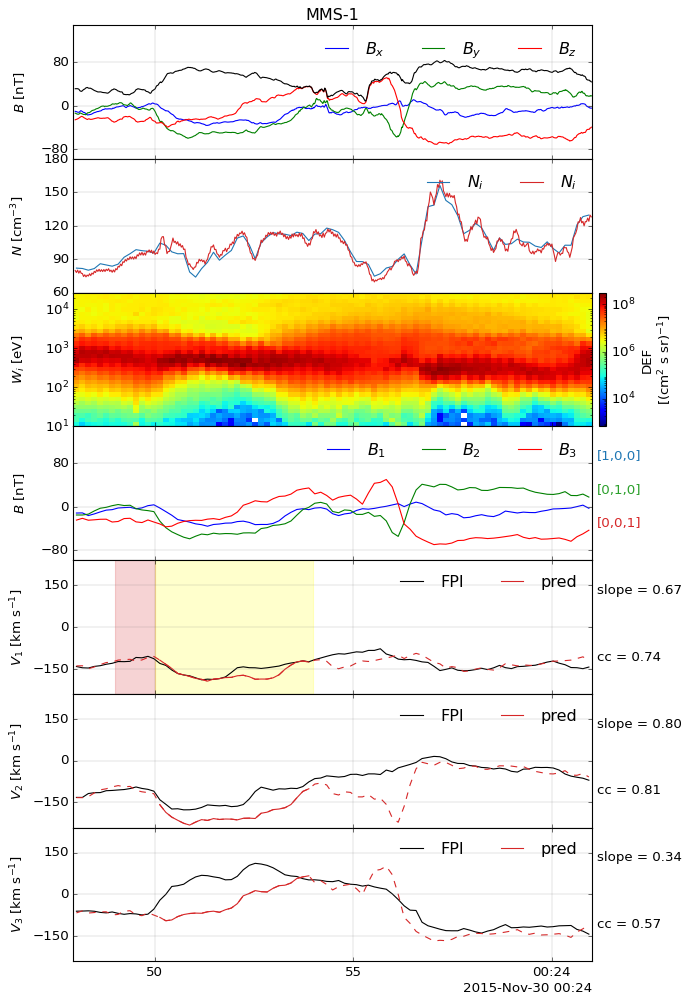

In [17]:
f, axs = plt.subplots(7, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.1, right=0.82, bottom=0.05, top=0.95)

plot_line(axs[0], b_gse)
plot_line(axs[0], pyrf.norm(b_gse), color="k")
axs[0].set_ylim([-98, 148])
axs[0].legend(["$B_x$", "$B_y$", "$B_z$"], ncol=3, frameon=False)
axs[0].set_ylabel("$B$ [nT]")
axs[0].set_title(f"MMS-{mms_id:d}")

plot_line(axs[1], n_i, color="tab:blue", label="$N_i$")
plot_line(axs[1], n_e, color="tab:red", label="$N_i$")
axs[1].legend(ncol=3, frameon=False)
axs[1].set_ylabel("$N$ [cm$^{-3}$]")


axs[2], caxs2 = plot_spectr(axs[2], def_omni_i, yscale="log", cscale="log")
axs[2].set_yticks(np.logspace(1, 4, 4))
axs[2].set_ylabel("$W_i$ [eV]")
caxs2.set_ylabel("DEF" + "\n" + "[(cm$^2$ s sr)$^{-1}$]")

plot_line(axs[3], b_123)
axs[3].set_ylim([-98, 148])
axs[3].legend(["$B_1$", "$B_2$", "$B_3$"], ncol=3, frameon=False)
axs[3].set_ylabel("$B$ [nT]")
axs[3].text(
    1.01,
    0.75,
    np.array2string(trans_matrix[0, :], separator=",", precision=2),
    color="tab:blue",
    transform=axs[3].transAxes,
)
axs[3].text(
    1.01,
    0.50,
    np.array2string(trans_matrix[1, :], separator=",", precision=2),
    color="tab:green",
    transform=axs[3].transAxes,
)
axs[3].text(
    1.01,
    0.25,
    np.array2string(trans_matrix[2, :], separator=",", precision=2),
    color="tab:red",
    transform=axs[3].transAxes,
)


plot_line(axs[4], v_123_i[:, 0], color="k", label="FPI")
plot_line(axs[4], v_i_pred2_w[:, 0], color="tab:red", linestyle="-", label="pred")
plot_line(axs[4], v_i_pred2[:, 0], color="tab:red", linestyle="--")
axs[4].legend(ncol=3, frameon=False)
axs[4].set_ylim([-240, 240])
axs[4].set_ylabel("$V_1$ [km s$^{-1}$]")
axs[4].text(
    1.01, 0.75, f"slope = {slope_2[0]:3.2f}", color="k", transform=axs[4].transAxes
)
axs[4].text(1.01, 0.25, f"cc = {cc_2[0]:3.2f}", color="k", transform=axs[4].transAxes)
axs[4].axvspan(
    mdates.datestr2num(tint_ref[0]),
    mdates.datestr2num(tint_ref[1]),
    color="tab:red",
    alpha=0.2,
)
axs[4].axvspan(
    mdates.datestr2num(tint_walen[0]),
    mdates.datestr2num(tint_walen[1]),
    color="yellow",
    alpha=0.2,
)


plot_line(axs[5], v_123_i[:, 1], color="k", label="FPI")
plot_line(axs[5], v_i_pred2_w[:, 1], color="tab:red", linestyle="-", label="pred")
plot_line(axs[5], v_i_pred2[:, 1], color="tab:red", linestyle="--")
axs[5].legend(ncol=3, frameon=False)
axs[5].set_ylim([-240, 240])
axs[5].set_ylabel("$V_2$ [km s$^{-1}$]")
axs[5].text(
    1.01, 0.75, f"slope = {slope_2[1]:3.2f}", color="k", transform=axs[5].transAxes
)
axs[5].text(1.01, 0.25, f"cc = {cc_2[1]:3.2f}", color="k", transform=axs[5].transAxes)


plot_line(axs[6], v_123_i[:, 2], color="k", label="FPI")
plot_line(axs[6], v_i_pred2_w[:, 2], color="tab:red", linestyle="-", label="pred")
plot_line(axs[6], v_i_pred2[:, 2], color="tab:red", linestyle="--")
axs[6].legend(ncol=3, frameon=False)
axs[6].set_ylim([-240, 240])
axs[6].set_ylabel("$V_3$ [km s$^{-1}$]")
axs[6].text(
    1.01, 0.75, f"slope = {slope_2[2]:3.2f}", color="k", transform=axs[6].transAxes
)
axs[6].text(1.01, 0.25, f"cc = {cc_2[2]:3.2f}", color="k", transform=axs[6].transAxes)

f.align_ylabels(axs)